In [0]:
import pandas as pd
import numpy as np
pd.plotting.register_matplotlib_converters()

from fbprophet import Prophet
from sklearn.metrics import mean_absolute_error as mae

import matplotlib.pyplot as plt
%matplotlib inline

In [24]:
path = 'https://github.com/dataworkshop/5dwchallenge_2019/blob/master/challenge5/input/visits.csv?raw=true'
df = pd.read_csv(path, parse_dates=['published'], index_col='published')
df.head()

,post_id
published,
2008-01-01 18:19:00,18284
2008-01-01 18:30:00,18285
2008-01-01 18:34:00,18286
2008-01-02 01:32:00,18291
2008-01-02 14:34:00,18294


In [25]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 134137 entries, 2008-01-01 18:19:00 to 2016-10-31 23:56:00
Data columns (total 1 columns):
post_id    134137 non-null int64
dtypes: int64(1)
memory usage: 2.0 MB


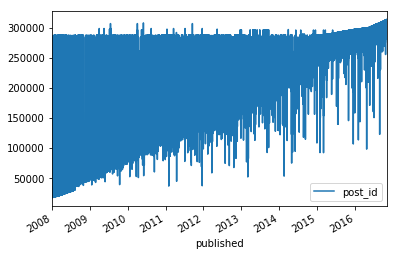

In [26]:
df.plot();

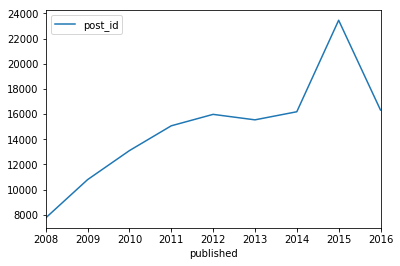

In [37]:
df.resample('1y').count().plot();

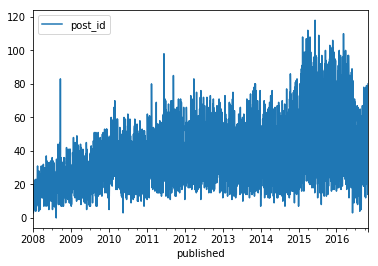

In [35]:
df.resample('1d').count().plot();

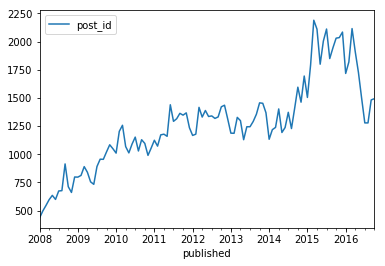

In [38]:
df.resample('1M').count().plot();

In [33]:
df.head()

,post_id
published,
2008-01-01 18:19:00,18284
2008-01-01 18:30:00,18285
2008-01-01 18:34:00,18286
2008-01-02 01:32:00,18291
2008-01-02 14:34:00,18294


In [42]:
df_day = df.resample('1d').count().reset_index()
df_day.columns = ['ds', 'y']
df_day.head()

,ds,y
0,2008-01-01,3
1,2008-01-02,3
2,2008-01-03,4
3,2008-01-04,14
4,2008-01-05,4


In [0]:
#train - do 30 punktów, test- od 30 do konca

num_points_to_pred = 100

train = df_day[:-num_points_to_pred]
test = df_day[-num_points_to_pred:]

In [76]:
m = Prophet()
m.fit(train)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [77]:
future = m.make_future_dataframe(periods=num_points_to_pred, freq='D', include_history=True)
future

,ds
0,2008-01-01
1,2008-01-02
2,2008-01-03
3,2008-01-04
4,2008-01-05
5,2008-01-06
6,2008-01-07
7,2008-01-08
8,2008-01-09
9,2008-01-10


In [0]:
forecast = m.predict(future)

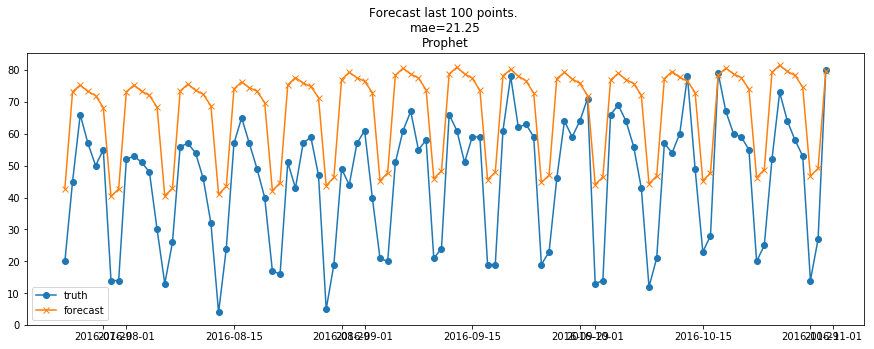

In [79]:
def plot_forecast(test, forecast):
  forecast = forecast[-num_points_to_pred:]
  score = np.round(mae(test.y, forecast.yhat), 2)
  
  plt.figure(figsize=(15, 5))
  plt.title('Forecast last {} points. \nmae={}\nProphet'.format(num_points_to_pred, score))
  plt.plot(test.ds, test.y, '-o', label='truth')
  plt.plot(test.ds, forecast.yhat, '-x', label='forecast')
  plt.legend()
             
plot_forecast(test, forecast)

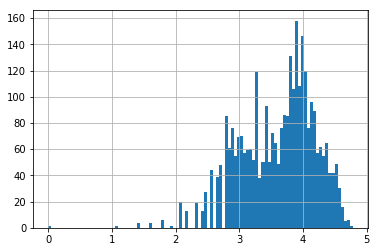

In [82]:
np.log1p(train.y).hist(bins=100);

In [0]:
num_points_to_pred = 100
train = df_day[:-num_points_to_pred]
test = df_day[-num_points_to_pred:]

train_log = train.copy()
train_log['y'] = np.log1p(train_log['y'])

In [88]:
m = Prophet(changepoint_prior_scale=0.01)
m.fit(train_log)
future = m.make_future_dataframe(periods=num_points_to_pred, \
                                 freq='D', include_history=False)


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [0]:
forecast = m.predict(future)
forecast['yhat'] = np.expm1(forecast.yhat)

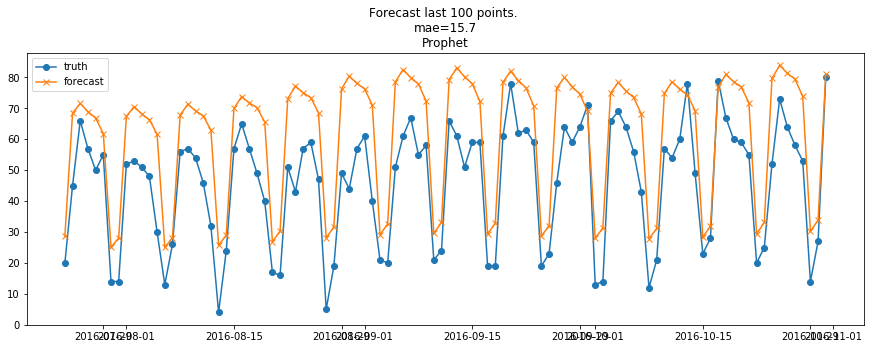

In [90]:
plot_forecast(test, forecast)

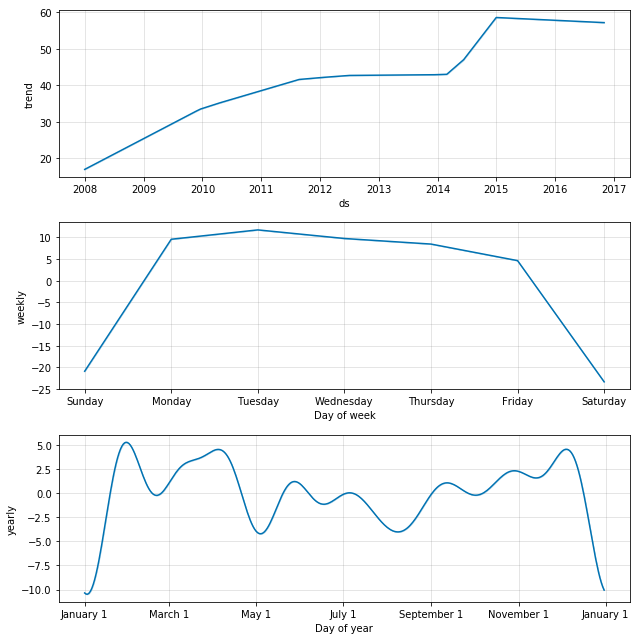

In [63]:
m.plot_components(forecast);

In [64]:
len(train), len(test)

(3197, 30)

In [65]:
from fbprophet.diagnostics import cross_validation

df_cv = cross_validation(m, initial='2500 days', period='10 days', horizon='30 days')

INFO:fbprophet:Making 67 forecasts with cutoffs between 2014-11-11 00:00:00 and 2016-09-01 00:00:00


In [66]:
df_cv.shape

(2010, 6)

In [67]:
df_cv.groupby('cutoff').count()

,ds,yhat,yhat_lower,yhat_upper,y
cutoff,,,,,
2014-11-11,30,30,30,30,30
2014-11-21,30,30,30,30,30
2014-12-01,30,30,30,30,30
2014-12-11,30,30,30,30,30
2014-12-21,30,30,30,30,30
2014-12-31,30,30,30,30,30
2015-01-10,30,30,30,30,30
2015-01-20,30,30,30,30,30
2015-01-30,30,30,30,30,30


In [0]:
from fbprophet.diagnostics import performance_metrics
from fbprophet.plot import plot_cross_validation_metric

In [70]:
performance_metrics(df_cv)

,horizon,mse,rmse,mae,mape,coverage
0,3 days,370.880636,19.258261,16.290693,0.564985,0.437811
1,4 days,335.711357,18.322428,15.725948,0.435991,0.437811
2,5 days,347.337215,18.636985,15.837603,0.477355,0.452736
3,6 days,350.526290,18.722347,15.645785,0.460709,0.477612
4,7 days,378.171895,19.446642,16.192848,0.468657,0.447761
5,8 days,369.704813,19.227710,15.850465,0.437131,0.467662
6,9 days,360.750587,18.993435,15.729791,0.436257,0.457711
7,10 days,403.976353,20.099163,16.484744,0.472290,0.452736
8,11 days,417.601795,20.435308,16.723957,0.585816,0.437811
9,12 days,424.907083,20.613274,17.236055,0.588839,0.407960


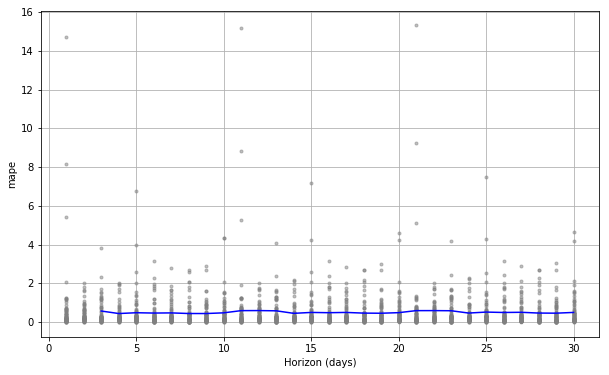

In [74]:
plot_cross_validation_metric(df_cv, 'mape');